In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2 as cv

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, cross_validate
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

In [2]:
DATAPATH = r"C:\Users\yuvfr\proj_university\swedish-leaf-classification\swedish-leaf-dataset"

In [3]:
IMG_SIZE = 224
LEAF_CLASSES = (9, 10)
leaf1, leaf2 = LEAF_CLASSES

In [4]:
def load_image(filename, height=IMG_SIZE, width=IMG_SIZE):
    img = cv.imread(filename, cv.IMREAD_COLOR)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = cv.resize(img, (height, width))
    return img

In [5]:
def load_leaf_data(leaf, label):
    leaf_path = os.path.join(DATAPATH,f"leaf{leaf}")
    leaf_imgs_list = []

    for img_fname in os.listdir(leaf_path):
        leaf_imgs_list.append(load_image(os.path.join(leaf_path, img_fname)))
    
    data = np.stack(leaf_imgs_list)
    label_arr = np.repeat(label, len(leaf_imgs_list)).reshape(-1,1)
    return data, label_arr
    

In [6]:
data1, label1 = load_leaf_data(leaf1, 0)
data2, label2 = load_leaf_data(leaf2, 1)

In [7]:
TEST_SIZE = 0.15

In [8]:
[(data.shape, label.shape, label[0]) for data, label in [(data1, label1), (data2, label2)]]

[((75, 224, 224, 3), (75, 1), array([0])),
 ((75, 224, 224, 3), (75, 1), array([1]))]

In [9]:
# split data equally
splits = [train_test_split(
    data, label, test_size=TEST_SIZE, random_state=42) 
          for data, label in [(data1, label1), (data2, label2)]]
X_train, X_test, y_train, y_test = [np.vstack(phase) for phase in zip(*splits)]
[arr.shape for arr in [X_train, y_train, X_test, y_test]]

[(126, 224, 224, 3), (126, 1), (24, 224, 224, 3), (24, 1)]

# Justification for PCA

In [11]:
full_pca = PCA(n_components=len(X_train))
full_pca.fit(X_train.reshape(len(X_train),-1))

PCA(n_components=126)

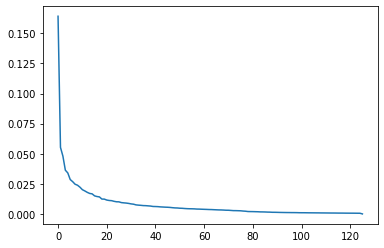

In [12]:
plt.plot(full_pca.explained_variance_ratio_)

# Model

In [13]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Define a Transformer that flats the images
def flat_image(x):
    return x.reshape(len(x),-1)

def inverse_flat_image(x, height=IMG_SIZE, width=IMG_SIZE, channels=3):
    return x.reshape(len(x), height, width, channels)

flat_transformer = FunctionTransformer(flat_image, inverse_flat_image)

# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA()

# Define a Standard Scaler to normalize inputs
scaler = StandardScaler()

log_reg = LogisticRegression(max_iter=10000)

pipe = Pipeline(steps=[("flat", flat_transformer), 
                       ("scaler", scaler), 
                       ("pca", pca), 
                       ("log_reg", log_reg)
                      ])

K_FOLDS = 6
param_grid = {
    "pca__n_components": np.ceil(np.logspace(
        start=2, stop=np.log2(len(X_train)*(K_FOLDS-1)/K_FOLDS),base=2, num=5)).astype(int),
    "log_reg__C": np.logspace(start=-4, stop=4, base=10, num=5),
}

search = GridSearchCV(pipe, param_grid, cv=K_FOLDS) # scoring="accuracy"
search.fit(X_train, y_train.reshape(-1,))
print(f"Best Hyperparameters: {search.best_params_}")
print(f"Best CV Accuracy: {search.best_score_:.4f}")

Best Hyperparameters: {'log_reg__C': 0.0001, 'pca__n_components': 4}
Best CV Accuracy: 1.0000


In [16]:
import wandb

wandb.init(project="swedish-leaf-classification", group="baseline",
           entity="yuvfried", job_type="notebook", name="poc_baseline",
           resume="allow", mode="online")

preds = search.predict(X_test).reshape(-1,1)
test_acc = (y_test == preds).sum() / len(y_test)
print(f"Test Accuracy: {test_acc:.4f}")

wandb.log({"test_acc":test_acc})
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: yuvfried (use `wandb login --relogin` to force relogin)


Test Accuracy: 1.0000


test_acc,▁
test_acc,1.0
